# YOLOv11 Object Detection on MOCS Dataset

## 1. Setup & Imports

In [1]:
!nvidia-smi

Tue May  6 22:27:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [3]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import cv2
import random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
!rm -rf sample_data
!wget https://nextcloud.ig.umons.ac.be/s/2JKrDkdcJgDt8Kj/download/MOCS_Small.zip
!unzip -q MOCS_Small.zip
!rm MOCS_Small.zip

--2025-05-06 22:29:39--  https://nextcloud.ig.umons.ac.be/s/2JKrDkdcJgDt8Kj/download/MOCS_Small.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://nextcloud.ig.umons.ac.be/public.php/dav/files/2JKrDkdcJgDt8Kj/?accept=zip [following]
--2025-05-06 22:29:41--  https://nextcloud.ig.umons.ac.be/public.php/dav/files/2JKrDkdcJgDt8Kj/?accept=zip
Reusing existing connection to nextcloud.ig.umons.ac.be:443.
HTTP request sent, awaiting response... 200 OK
Length: 814230939 (777M) [application/zip]
Saving to: ‘MOCS_Small.zip’

MOCS_Small.zip      100%[===================>] 776.51M  12.4MB/s    in 58s     

2025-05-06 22:30:39 (13.4 MB/s) - ‘MOCS_Small.zip’ saved [814230939/814230939]



## 2. Set Training Parameters

In [5]:
# Define interactive parameters
model_to_be_trained = "yolo11s"  #@param ["yolo11n", "yolo11s", "yolo11m", "yolo11l", "yolo11x"]
nbr_epochs = 10  #@param {type:"integer"}
img_size = 640  #@param {type:"integer"}
batch_size = 32  #@param {type:"integer"}
load_weights = True  #@param {type:"boolean"}
test_conf_level = 0.4  #@param {type:"slider", min:0, max:1, step:0.05}

In [6]:
# Set hyperparameters manually for compatibility with argparse usage
class Args:
    epochs = nbr_epochs
    imgsz = img_size
    batch = batch_size

args = Args()

In [7]:
data_yaml_content = """path: .
train: /content/MOCS_Small/Small/train
val: /content/MOCS_Small/Small/val
test: /content/MOCS_Small/Small/test
batch: 32
imgsz: 640
names:
  0: Worker
  1: Static crane
  2: Hanging head
  3: Crane
  4: Roller
  5: Bulldozer
  6: Excavator
  7: Truck
  8: Loader
  9: Pump truck
  10: Concrete mixer
  11: Pile driving
  12: Other vehicle
"""

# Write the content to data.yaml
with open('data.yaml', 'w') as file:
    file.write(data_yaml_content)

## 3. Visualize Sample Annotated Images

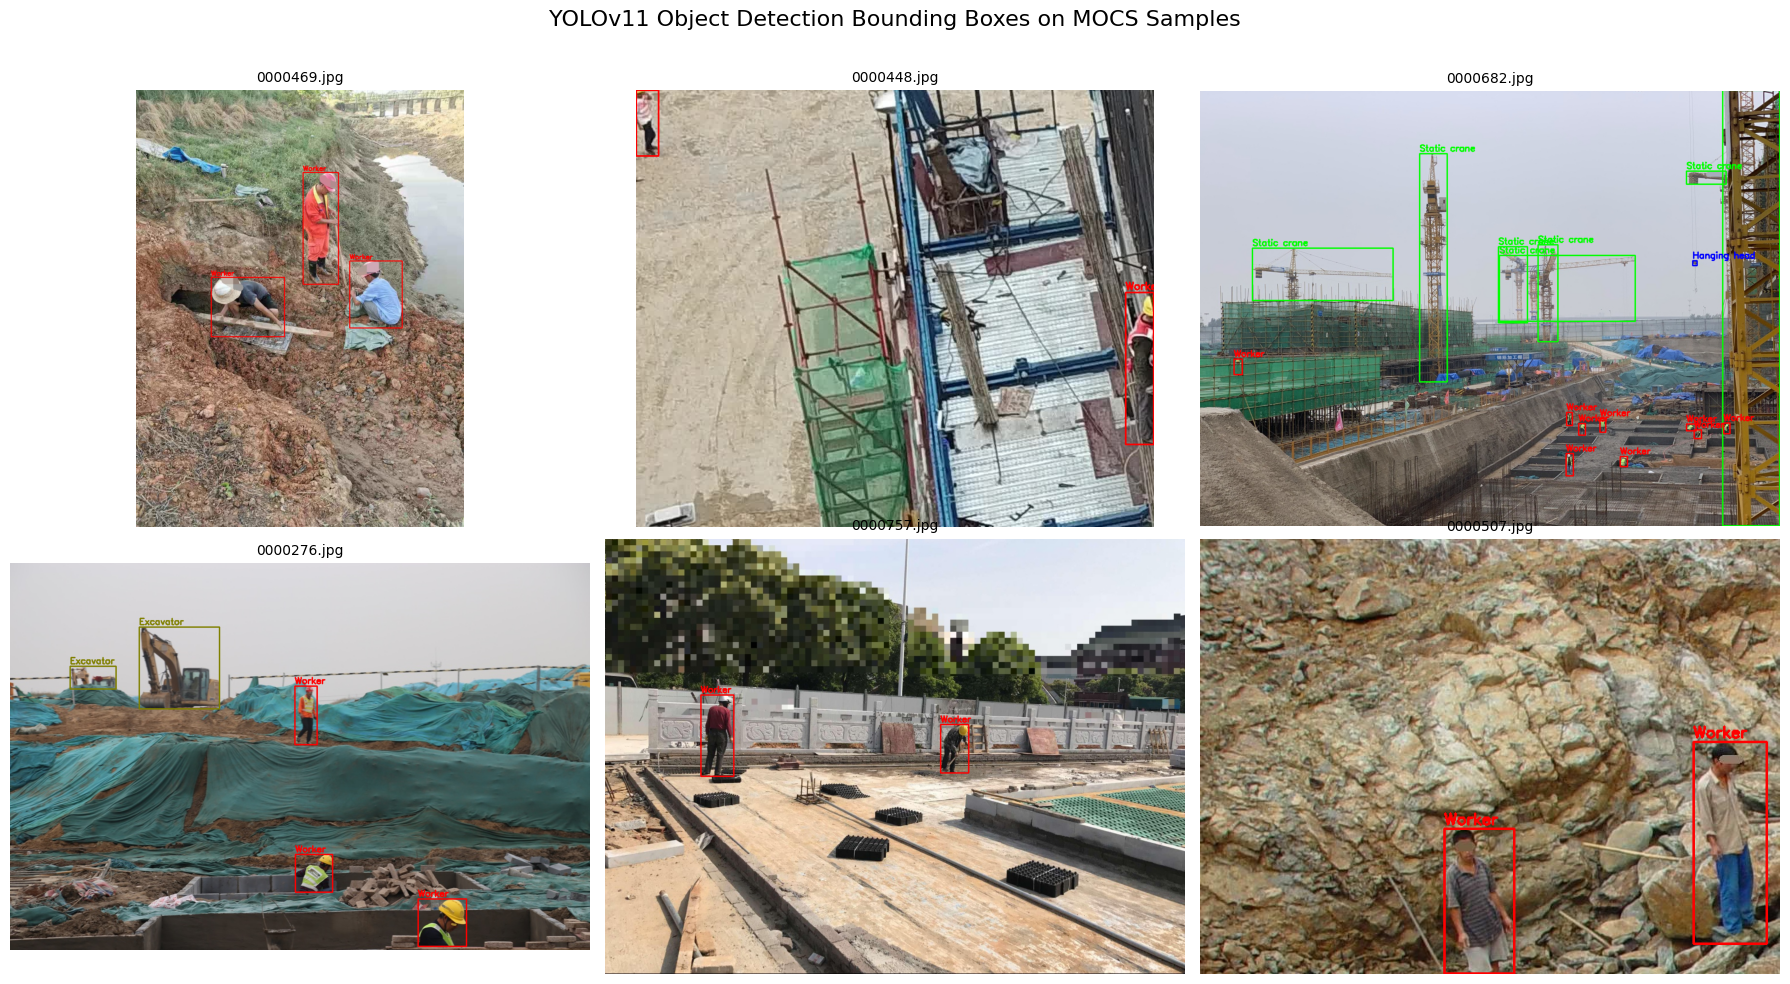

In [8]:
image_dir = "MOCS_Small/Small/val/images"
label_dir = "MOCS_Small/Small/val/labels"

# Class color map
CLASS_NAMES = {
    0: "Worker", 1: "Static crane", 2: "Hanging head", 3: "Crane",
    4: "Roller", 5: "Bulldozer", 6: "Excavator", 7: "Truck",
    8: "Loader", 9: "Pump truck", 10: "Concrete mixer",
    11: "Pile driving", 12: "Other vehicle"
}

CLASS_COLORS = {
    0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255), 3: (255, 255, 0),
    4: (255, 0, 255), 5: (0, 255, 255), 6: (128, 128, 0), 7: (128, 0, 128),
    8: (0, 128, 128), 9: (100, 100, 255), 10: (255, 100, 100),
    11: (100, 255, 100), 12: (200, 200, 200)
}

image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
sample_images = random.sample(image_files, 6)

def draw_bboxes(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                cls, cx, cy, bw, bh = map(float, line.strip().split())
                cls = int(cls)
                x1 = int((cx - bw / 2) * w)
                y1 = int((cy - bh / 2) * h)
                x2 = int((cx + bw / 2) * w)
                y2 = int((cy + bh / 2) * h)
                color = CLASS_COLORS.get(cls, (255, 255, 255))
                label = CLASS_NAMES.get(cls, str(cls))
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return image

plt.figure(figsize=(18, 10))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))
    vis_img = draw_bboxes(img_path, label_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(vis_img)
    plt.title(f"{img_name}", fontsize=10)
    plt.axis("off")

plt.suptitle("YOLOv11 Object Detection Bounding Boxes on MOCS Samples", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## 4. Load the Model

In [9]:
model = YOLO(f"{model_to_be_trained}.pt")  # Load YOLOv11 object detection model

100%|██████████| 18.4M/18.4M [00:00<00:00, 120MB/s] 


## 5. Train the Model on MOCS

In [10]:
model.train(
    data='data.yaml',  # Replace with actual MOCS data.yaml path
    epochs=args.epochs,
    imgsz=args.imgsz,
    batch=args.batch,
    workers=0,
    project="YOLOv11_MOCS",
    name="yolov11_object_detection"
)

Ultralytics 8.3.128 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11_object_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

100%|██████████| 755k/755k [00:00<00:00, 22.7MB/s]

Overriding model.yaml nc=80 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytic

 13                  -1  1    443776  ultralytics.nn.modules.block.C3k2            [768, 256, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    127680  ultralytics.nn.modules.block.C3k2            [512, 128, 1, False]          
 17                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1    345472  ultralytics.nn.modules.block.C3k2            [384, 256, 1, False]          
 20                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 94.2MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2455.9±1751.4 MB/s, size: 252.6 KB)


train: Scanning /content/MOCS_Small/Small/train/labels... 1500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1500/1500 [00:00<00:00, 2265.34it/s]

train: New cache created: /content/MOCS_Small/Small/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2131.4±987.3 MB/s, size: 276.1 KB)


val: Scanning /content/MOCS_Small/Small/val/labels... 220 images, 0 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:00<00:00, 2101.72it/s]

val: New cache created: /content/MOCS_Small/Small/val/labels.cache


Plotting labels to YOLOv11_MOCS/yolov11_object_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to YOLOv11_MOCS/yolov11_object_detection
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      7.94G      1.281      3.291      1.128        161        640: 100%|██████████| 47/47 [00:58<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

                   all        220       1391      0.194      0.297      0.204      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      7.94G      1.314      1.714      1.144        148        640: 100%|██████████| 47/47 [00:55<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        220       1391      0.549      0.244      0.272      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         8G      1.322      1.484      1.145        162        640: 100%|██████████| 47/47 [00:56<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        220       1391      0.375      0.358      0.302      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      8.01G      1.342      1.411      1.157        187        640: 100%|██████████| 47/47 [00:56<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        220       1391      0.454      0.262       0.27       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      8.02G      1.319      1.314      1.155        219        640: 100%|██████████| 47/47 [00:56<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        220       1391      0.519      0.363      0.376      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      7.97G      1.274      1.198      1.112        171        640: 100%|██████████| 47/47 [00:56<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        220       1391      0.604      0.412      0.449      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      7.99G      1.223      1.092      1.096        169        640: 100%|██████████| 47/47 [00:59<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        220       1391      0.596      0.466       0.48      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      7.94G      1.157      1.019      1.062        137        640: 100%|██████████| 47/47 [00:56<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        220       1391      0.621      0.479      0.527       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      7.95G      1.108     0.9328       1.04        116        640: 100%|██████████| 47/47 [00:56<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        220       1391      0.678      0.512      0.573      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      7.96G      1.071     0.8766      1.027        150        640: 100%|██████████| 47/47 [00:55<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        220       1391      0.643      0.531      0.571      0.387



10 epochs completed in 0.172 hours.
Optimizer stripped from YOLOv11_MOCS/yolov11_object_detection/weights/last.pt, 19.2MB
Optimizer stripped from YOLOv11_MOCS/yolov11_object_detection/weights/best.pt, 19.2MB

Validating YOLOv11_MOCS/yolov11_object_detection/weights/best.pt...
Ultralytics 8.3.128 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,417,831 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


                   all        220       1391      0.675      0.516      0.573       0.39
                Worker        169        883      0.785      0.693      0.754      0.441
          Static crane         43        102      0.636      0.702      0.709      0.437
          Hanging head         26         36      0.612      0.417      0.426      0.268
                 Crane         27         40      0.564       0.45       0.44      0.224
                Roller          5          5       0.62      0.344      0.398      0.324
             Bulldozer         14         15      0.683        0.8      0.742      0.607
             Excavator         68         96      0.779      0.812      0.836      0.617
                 Truck         39         64      0.599      0.406       0.53      0.363
                Loader         16         18      0.827      0.268      0.404      0.283
            Pump truck         15         15      0.764      0.667      0.737       0.54
        Concrete mixe

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a338ee59590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

## 6. Validate the Model

In [11]:
metrics = model.val()
print("Validation metrics:", metrics)

Ultralytics 8.3.128 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,417,831 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2873.6±194.9 MB/s, size: 237.6 KB)


val: Scanning /content/MOCS_Small/Small/val/labels.cache... 220 images, 0 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


                   all        220       1391      0.673       0.52      0.575      0.392
                Worker        169        883      0.781      0.694      0.755      0.445
          Static crane         43        102      0.634      0.706      0.709      0.437
          Hanging head         26         36      0.608      0.417      0.424       0.27
                 Crane         27         40      0.562      0.475      0.447      0.231
                Roller          5          5      0.637      0.364      0.398      0.326
             Bulldozer         14         15      0.676        0.8      0.743      0.608
             Excavator         68         96      0.775      0.812      0.836      0.618
                 Truck         39         64       0.61      0.406      0.528      0.361
                Loader         16         18      0.834       0.28      0.405      0.281
            Pump truck         15         15      0.752      0.667      0.757      0.553
        Concrete mixe

## 7. Run Inference on New Images


image 1/1 /content/MOCS_Small/Small/test/images/0000089.jpg: 384x640 6 Workers, 2 Excavators, 1 Pump truck, 2 Concrete mixers, 11.8ms
Speed: 3.5ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


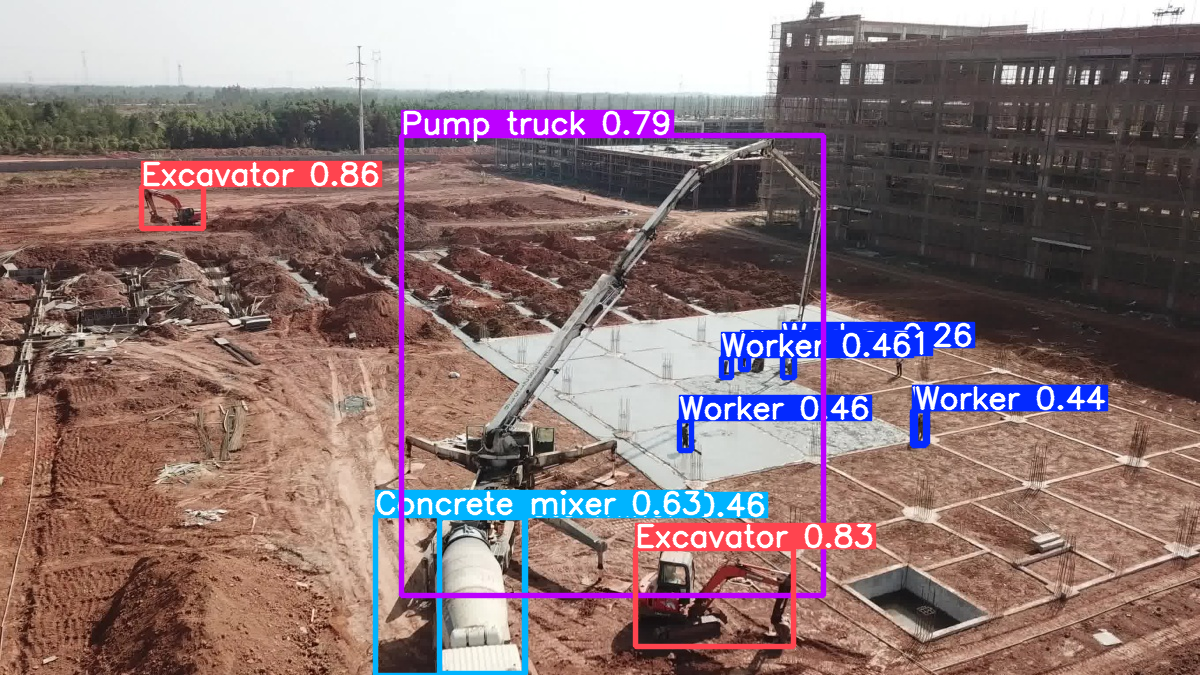

In [22]:
results = model.predict(source="MOCS_Small/Small/test/images/0000089.jpg", save=False)
results[0].show()

## 8. Visualize Key Outputs (Confusion Matrix, PR Curve, etc.)

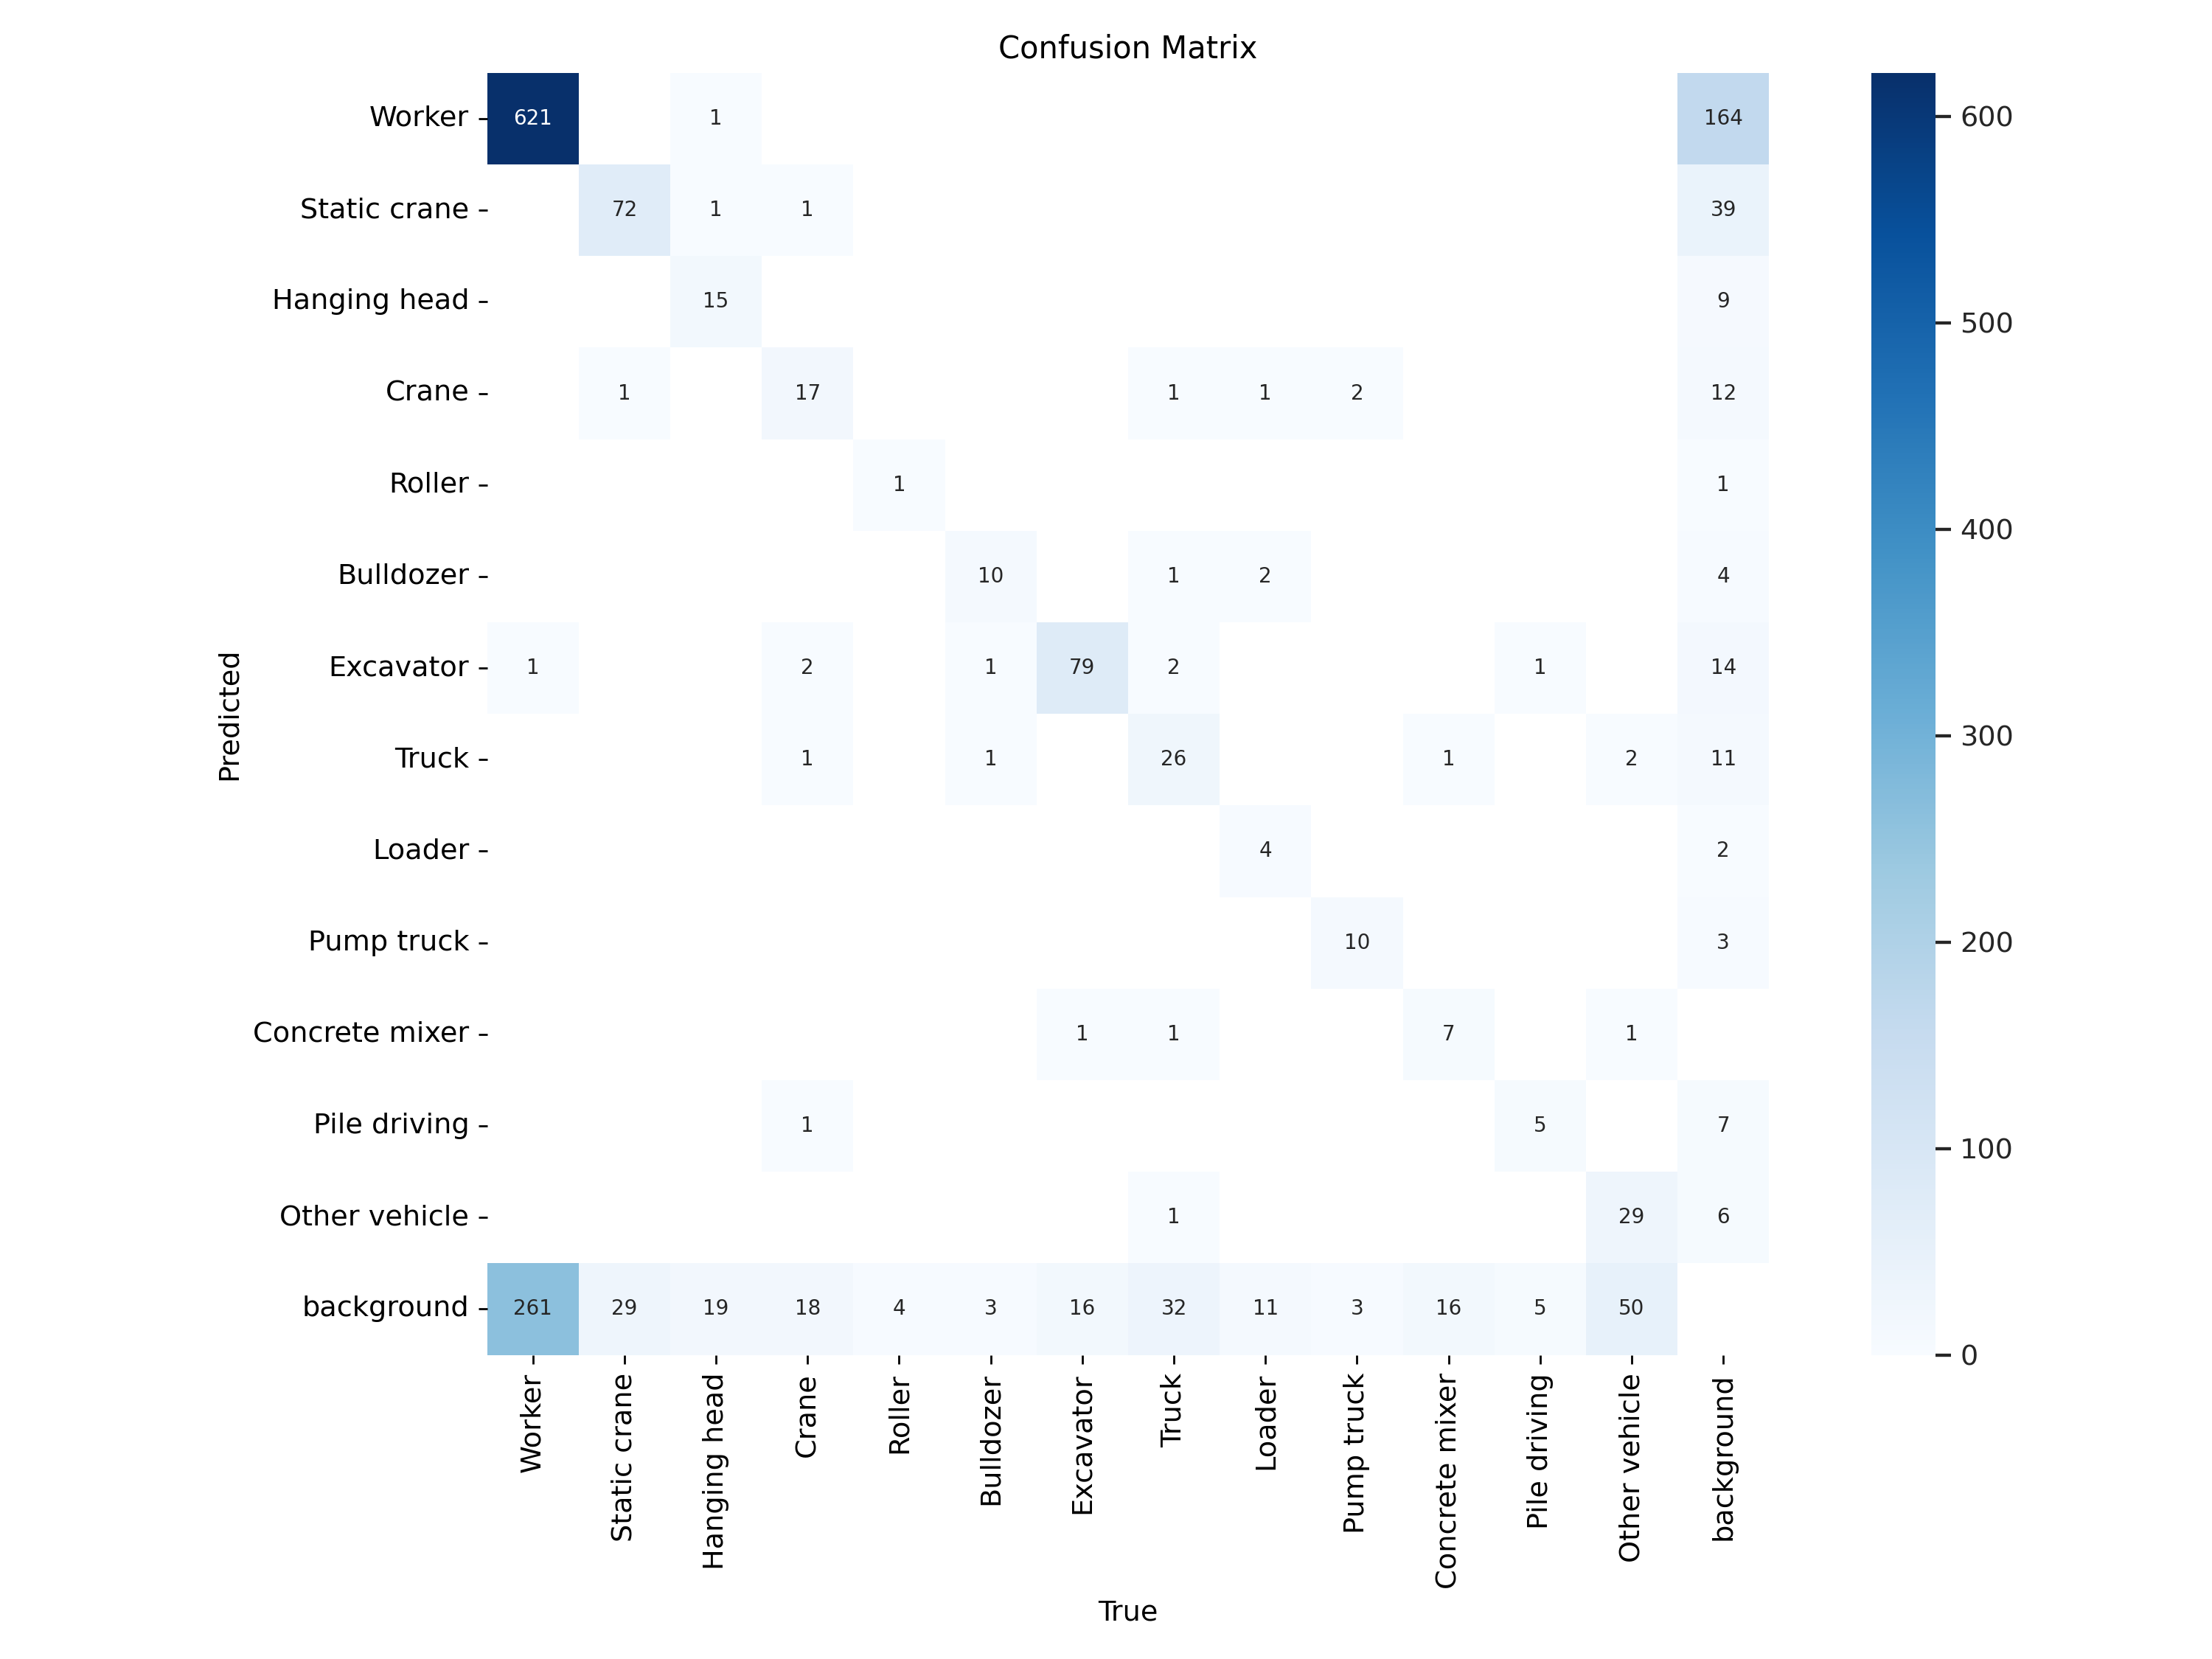

results.png not found in YOLOv11_MOCS/yolov11_object_detection2


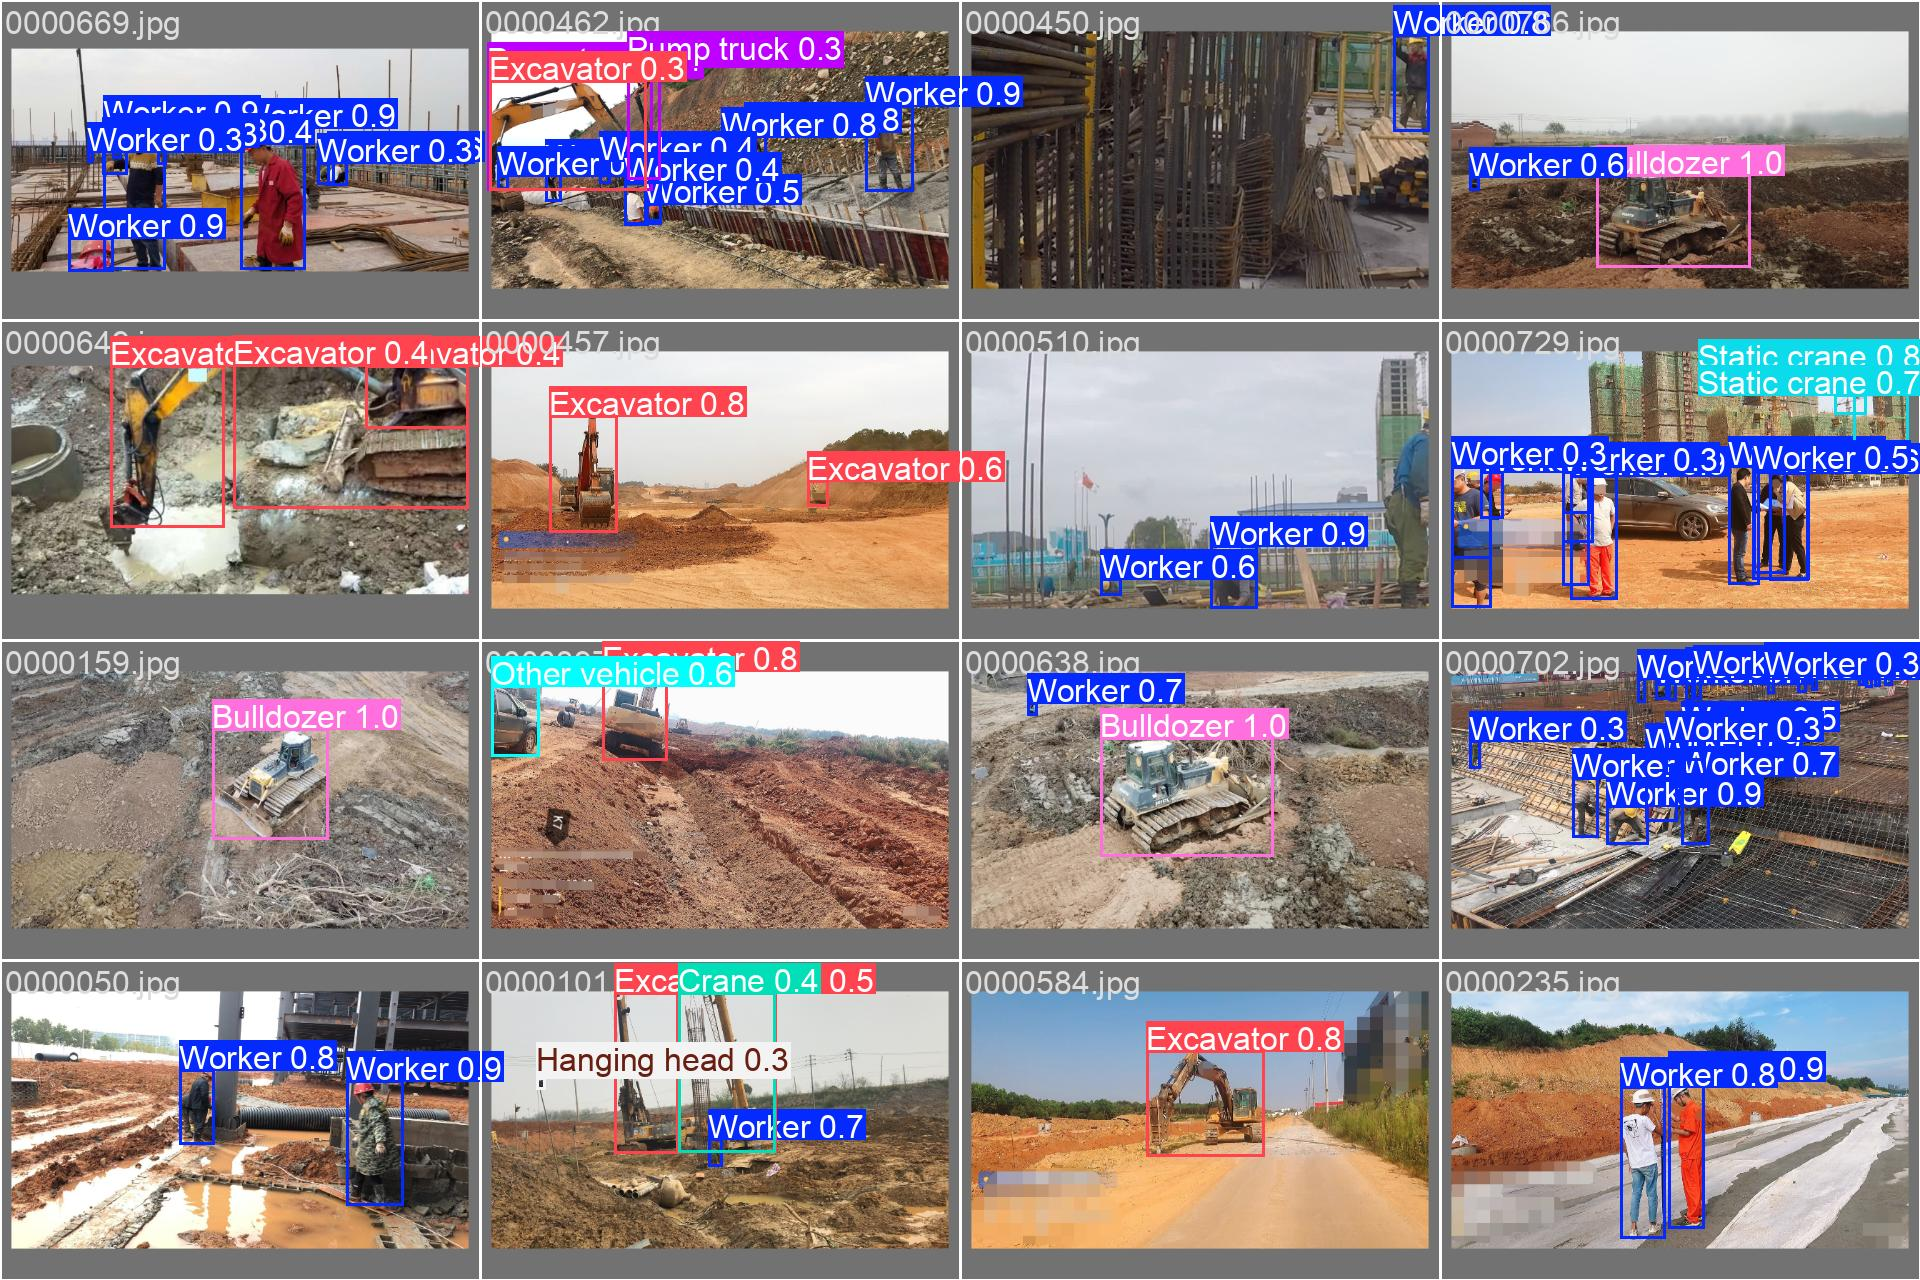

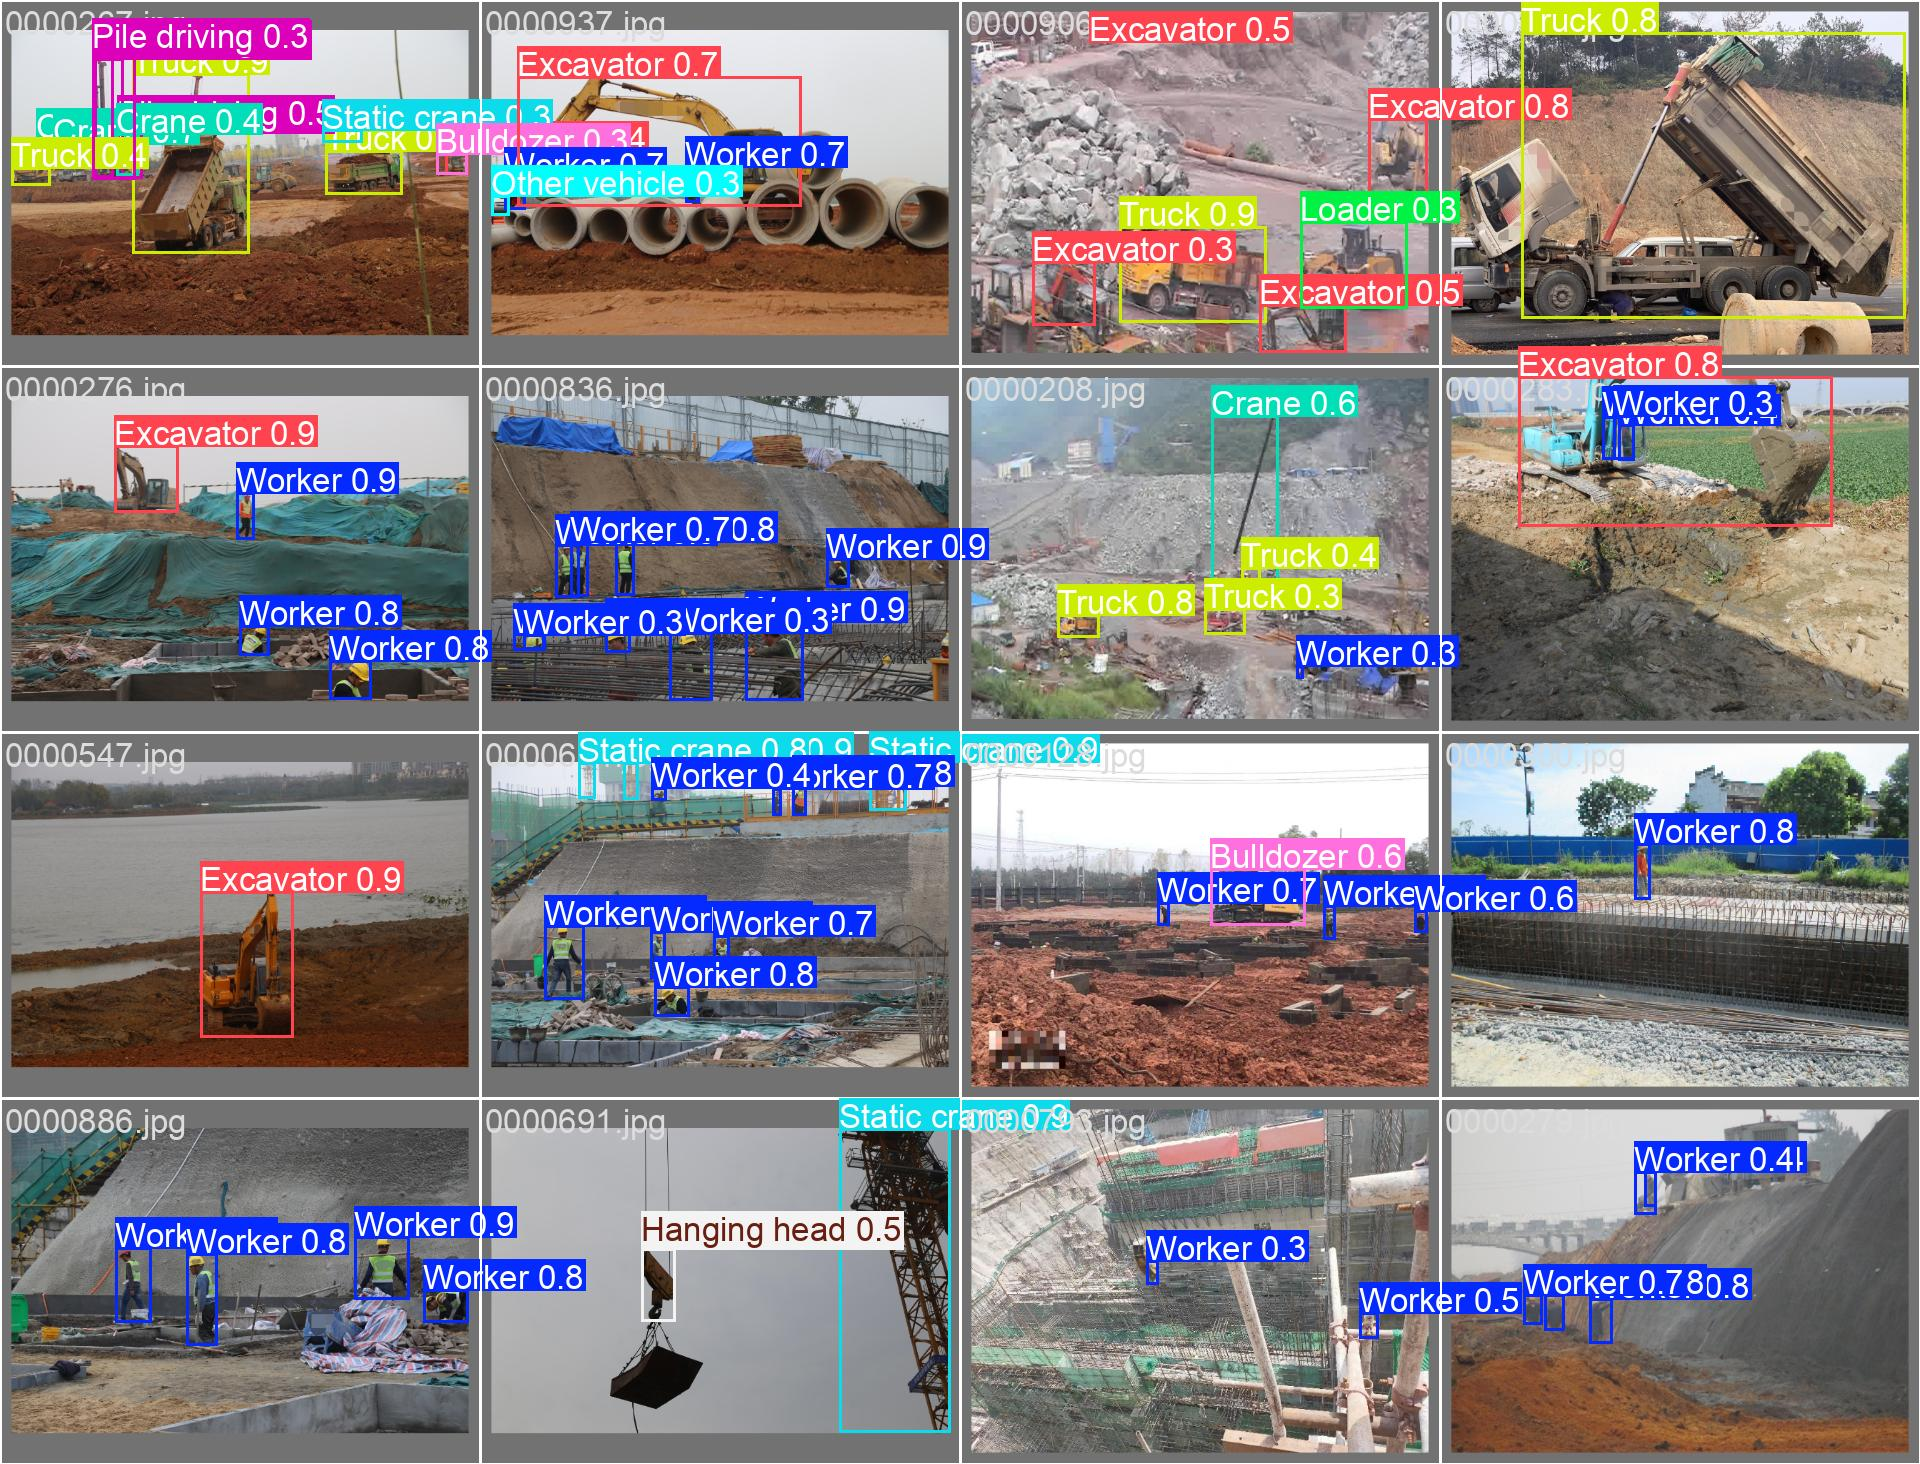

In [13]:
output_dir = "YOLOv11_MOCS/yolov11_object_detection2" # make sure the path is correct

figures = [
    "confusion_matrix.png",
    "results.png",
    "val_batch0_pred.jpg",
    "val_batch1_pred.jpg"
]

for fig in figures:
    fig_path = os.path.join(output_dir, fig)
    if os.path.exists(fig_path):
        display(Image(filename=fig_path))
    else:
        print(f"{fig} not found in {output_dir}")

## 9. Export the model to engine (Quantization)

In [15]:
# this should be done on the Jetson Card but it is shown as example
"""
out = model.export(format="engine",
                   imgsz=640,
                   dynamic=True,
                   verbose=False,
                   batch=8,
                   half=True)
"""

'\nout = model.export(format="engine",\n                   imgsz=640,\n                   dynamic=True,\n                   verbose=False,\n                   batch=8,\n                   half=True)\n'